In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.express as px

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score 
import tensorflow as tf
from tensorflow.keras import regularizers



<h3>Prepare Datasets</h3>

In [2]:
train_dataset = pd.read_csv('Datasets/train_dataset.csv')
test_dataset = pd.read_csv('Datasets/test_dataset.csv')

train_pca_dataset = pd.read_csv('Datasets/PCA_train_data.csv')
test_pca_dataset = pd.read_csv('Datasets/PCA_test_data.csv')

train_tree_dataset = pd.read_csv('Datasets/Tree_train_data.csv')
test_tree_dataset = pd.read_csv('Datasets/Tree_test_data.csv')


X_train = train_dataset.drop(['is_attack' , 'attack_category' , 'attack'], axis=1)
y_train = train_dataset['attack_category']

X_test = test_dataset.drop(['is_attack' , 'attack_category' , 'attack'], axis=1)
y_test = test_dataset['attack_category']

from tensorflow.keras.utils import to_categorical

# Convert integer labels to one-hot encoded format
y_train_one_hot = to_categorical(y_train, num_classes=5)
y_test_one_hot = to_categorical(y_test, num_classes=5)

X_pca_train = train_pca_dataset.drop(['is_attack' , 'attack_category' , 'attack'], axis=1)
y_pca_train = train_pca_dataset['attack_category']

X_pca_test = test_pca_dataset.drop(['is_attack' , 'attack_category' , 'attack'], axis=1)
y_pca_test = test_pca_dataset['attack_category']

X_tree_train = train_tree_dataset.drop(['is_attack' , 'attack_category' , 'attack'], axis=1)
y_tree_train = train_tree_dataset['attack_category']

X_tree_test = test_tree_dataset.drop(['is_attack' , 'attack_category' , 'attack'], axis=1)
y_tree_test = test_tree_dataset['attack_category']

In [3]:
def train_model(model, X, y):
    skf = StratifiedKFold(n_splits=5)

    accuracy_scores = []
    precision_scores = []
    recall_scores = []
    f1_scores = []

    for train_index, test_index in skf.split(X, y):
        X_train, y_train = X.iloc[train_index], y.iloc[train_index]
        X_test, y_test = X.iloc[test_index], y.iloc[test_index]

        model.fit(X_train, y_train)

        pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, pred)
        precision = precision_score(y_test, pred, average='weighted')
        recall = recall_score(y_test, pred, average='weighted') 
        f1 = f1_score(y_test, pred, average='weighted') 

        accuracy_scores.append(accuracy)
        precision_scores.append(precision)
        recall_scores.append(recall)
        f1_scores.append(f1)

    # print('{0} Accuracy: {1: .5f} Precision: {2: .5f} Recall: {3: .5f} F1_Score: {4: .5f}'.format(
    #     model.__class__.__name__, 
    #     np.mean(accuracy_scores),
    #     np.mean(precision_scores),
    #     np.mean(recall_scores),
    #     np.mean(f1_scores)))
    
    return -np.mean(f1_scores)

In [4]:
def evaluate(model, X_train, y_train, X_test, y_test):
    
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    print("Model: ", model.__class__.__name__)
    print("Accuracy: ", accuracy)
    print("Precision: ", precision)
    print("Recall: ", recall)
    print("F1 Score: ", f1)
    print("####################################")
    
    # report = classification_report(y_test, y_pred)
    # print("Classification Report:\n", report)
    
    return -f1

<h3> Model for Neural Network without PCA or Tree </h3>

In [5]:
num_classes = 5

nn_model = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu', input_shape=(X_train.shape[1:]), 
                          kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4), 
                          bias_regularizer=regularizers.L2(1e-4),
                          activity_regularizer=regularizers.L2(1e-5)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(units=128, activation='relu', 
                          kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4), 
                          bias_regularizer=regularizers.L2(1e-4),
                          activity_regularizer=regularizers.L2(1e-5)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(units=512, activation='relu', 
                          kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4), 
                          bias_regularizer=regularizers.L2(1e-4),
                          activity_regularizer=regularizers.L2(1e-5)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(units=128, activation='relu', 
                          kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4), 
                          bias_regularizer=regularizers.L2(1e-4),
                          activity_regularizer=regularizers.L2(1e-5)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(units=num_classes, activation='softmax'),  # Change to softmax for multiclass
])


In [6]:
nn_model.compile(optimizer='adam', 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=['accuracy'])


In [7]:
nn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                2944      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 512)               66048     
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 128)               6

In [8]:
nn_history = nn_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, verbose=1)

Epoch 1/10
3937/3937 [==============================] - 44s 11ms/step - loss: 0.1832 - accuracy: 0.9647 - val_loss: 1.6180 - val_accuracy: 0.7656
Epoch 2/10
3937/3937 [==============================] - 41s 11ms/step - loss: 0.0996 - accuracy: 0.9783 - val_loss: 1.6721 - val_accuracy: 0.7543
Epoch 3/10
3937/3937 [==============================] - 36s 9ms/step - loss: 0.0877 - accuracy: 0.9809 - val_loss: 1.5172 - val_accuracy: 0.7640
Epoch 4/10
3937/3937 [==============================] - 41s 10ms/step - loss: 0.0869 - accuracy: 0.9814 - val_loss: 1.3697 - val_accuracy: 0.7821
Epoch 5/10
3937/3937 [==============================] - 38s 10ms/step - loss: 0.0830 - accuracy: 0.9827 - val_loss: 1.5728 - val_accuracy: 0.7500
Epoch 6/10
3937/3937 [==============================] - 43s 11ms/step - loss: 0.0811 - accuracy: 0.9829 - val_loss: 1.3258 - val_accuracy: 0.7588
Epoch 7/10
3937/3937 [==============================] - 41s 10ms/step - loss: 0.0806 - accuracy: 0.9836 - val_loss: 1.9052 - 

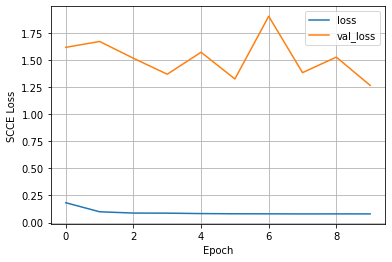

In [11]:
plt.plot(nn_history.history['loss'], label='loss')
plt.plot(nn_history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('SCCE Loss')
plt.legend()
plt.grid(True)

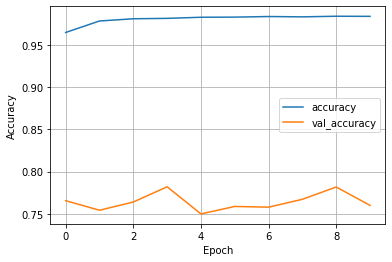

In [12]:
plt.plot(nn_history.history['accuracy'], label='accuracy')
plt.plot(nn_history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

In [14]:
y_pred_probs = nn_model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=-1)


accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Print the metrics
print("Accuracy for no PCA and no tree:", accuracy)
print("Precision for no PCA and no tree:", precision)
print("Recall for no PCA and no tree:", recall)
print("F1 Score for no PCA and no tree:", f1)

705/705 [==============================] - 3s 5ms/step
Accuracy for no PCA and no tree: 0.7600691980127751
Precision for no PCA and no tree: 0.7830333174270425
Recall for no PCA and no tree: 0.7600691980127751
F1 Score for no PCA and no tree: 0.712749664336093


<h3> Neural networks with PCA </h3>

In [15]:
nn_model_pca = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu', input_shape=(X_pca_train.shape[1:]), 
                          kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4), 
                          bias_regularizer=regularizers.L2(1e-4),
                          activity_regularizer=regularizers.L2(1e-5)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(units=128, activation='relu', 
                          kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4), 
                          bias_regularizer=regularizers.L2(1e-4),
                          activity_regularizer=regularizers.L2(1e-5)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(units=512, activation='relu', 
                          kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4), 
                          bias_regularizer=regularizers.L2(1e-4),
                          activity_regularizer=regularizers.L2(1e-5)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(units=128, activation='relu', 
                          kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4), 
                          bias_regularizer=regularizers.L2(1e-4),
                          activity_regularizer=regularizers.L2(1e-5)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(units=num_classes, activation='softmax'),  # Change to softmax for multiclass
])

In [17]:
nn_model_pca.compile(optimizer='adam', 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=['accuracy'])

In [18]:
nn_history_pca = nn_model_pca.fit(X_pca_train, y_pca_train, validation_data=(X_pca_test, y_pca_test), epochs=10, verbose=1)

Epoch 1/10
3937/3937 [==============================] - 43s 10ms/step - loss: 0.2099 - accuracy: 0.9574 - val_loss: 1.2916 - val_accuracy: 0.7359
Epoch 2/10
3937/3937 [==============================] - 48s 12ms/step - loss: 0.1283 - accuracy: 0.9700 - val_loss: 1.5761 - val_accuracy: 0.7417
Epoch 3/10
3937/3937 [==============================] - 47s 12ms/step - loss: 0.1165 - accuracy: 0.9722 - val_loss: 1.5490 - val_accuracy: 0.7620
Epoch 4/10
3937/3937 [==============================] - 45s 11ms/step - loss: 0.1118 - accuracy: 0.9726 - val_loss: 1.5730 - val_accuracy: 0.7590
Epoch 5/10
3937/3937 [==============================] - 38s 10ms/step - loss: 0.1100 - accuracy: 0.9735 - val_loss: 1.4353 - val_accuracy: 0.7791
Epoch 6/10
3937/3937 [==============================] - 39s 10ms/step - loss: 0.1062 - accuracy: 0.9737 - val_loss: 1.8247 - val_accuracy: 0.7549
Epoch 7/10
3937/3937 [==============================] - 47s 12ms/step - loss: 0.1076 - accuracy: 0.9739 - val_loss: 1.4546 -

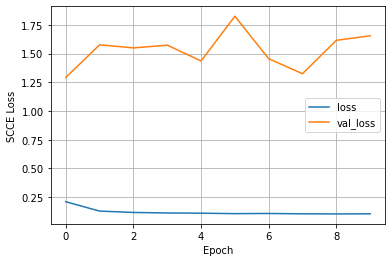

In [19]:
plt.plot(nn_history_pca.history['loss'], label='loss')
plt.plot(nn_history_pca.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('SCCE Loss')
plt.legend()
plt.grid(True)

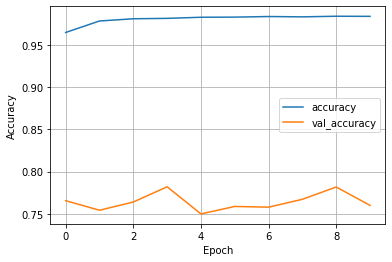

In [20]:
plt.plot(nn_history.history['accuracy'], label='accuracy')
plt.plot(nn_history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

In [21]:
y_pred_probs_pca = nn_model_pca.predict(X_pca_test)
y_pred_pca = np.argmax(y_pred_probs_pca, axis=-1)


accuracy_pca = accuracy_score(y_pca_test, y_pred_pca)
precision_pca = precision_score(y_pca_test, y_pred_pca, average='weighted')
recall_pca = recall_score(y_pca_test, y_pred_pca, average='weighted')
f1_pca = f1_score(y_pca_test, y_pred_pca, average='weighted')

# Print the metrics
print("Accuracy for PCA:", accuracy_pca)
print("Precision for PCA:", precision_pca)
print("Recall for PCA:", recall_pca)
print("F1 Score for PCA:", f1_pca)

705/705 [==============================] - 3s 3ms/step
Accuracy for PCA: 0.7543914123491838
Precision for PCA: 0.7988732865228201
Recall for PCA: 0.7543914123491838
F1 Score for PCA: 0.7219661737682376


<h3> Neural networks for tree </h3>

In [22]:
nn_model_tree = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu', input_shape=(X_tree_train.shape[1:]), 
                          kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4), 
                          bias_regularizer=regularizers.L2(1e-4),
                          activity_regularizer=regularizers.L2(1e-5)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(units=128, activation='relu', 
                          kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4), 
                          bias_regularizer=regularizers.L2(1e-4),
                          activity_regularizer=regularizers.L2(1e-5)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(units=512, activation='relu', 
                          kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4), 
                          bias_regularizer=regularizers.L2(1e-4),
                          activity_regularizer=regularizers.L2(1e-5)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(units=128, activation='relu', 
                          kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4), 
                          bias_regularizer=regularizers.L2(1e-4),
                          activity_regularizer=regularizers.L2(1e-5)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(units=num_classes, activation='softmax'),  # Change to softmax for multiclass
])

In [23]:
nn_model_tree.compile(optimizer='adam', 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=['accuracy'])

In [24]:
nn_history_tree = nn_model_tree.fit(X_tree_train, y_tree_train, validation_data=(X_tree_test, y_tree_test), epochs=10, verbose=1)

Epoch 1/10
3937/3937 [==============================] - 39s 9ms/step - loss: 0.1821 - accuracy: 0.9646 - val_loss: 1.2898 - val_accuracy: 0.7448
Epoch 2/10
3937/3937 [==============================] - 40s 10ms/step - loss: 0.1021 - accuracy: 0.9772 - val_loss: 1.4334 - val_accuracy: 0.7548
Epoch 3/10
3937/3937 [==============================] - 38s 10ms/step - loss: 0.0917 - accuracy: 0.9795 - val_loss: 1.7830 - val_accuracy: 0.7650
Epoch 4/10
3937/3937 [==============================] - 38s 10ms/step - loss: 0.0878 - accuracy: 0.9806 - val_loss: 1.3965 - val_accuracy: 0.7692
Epoch 5/10
3937/3937 [==============================] - 37s 9ms/step - loss: 0.0855 - accuracy: 0.9820 - val_loss: 1.4971 - val_accuracy: 0.7599
Epoch 6/10
3937/3937 [==============================] - 37s 9ms/step - loss: 0.0841 - accuracy: 0.9817 - val_loss: 1.4971 - val_accuracy: 0.7687
Epoch 7/10
3937/3937 [==============================] - 38s 10ms/step - loss: 0.0820 - accuracy: 0.9825 - val_loss: 1.7918 - va

In [25]:
y_pred_probs_tree = nn_model_tree.predict(X_tree_test)
y_pred_tree = np.argmax(y_pred_probs_tree, axis=-1)


accuracy_tree = accuracy_score(y_tree_test, y_pred_tree)
precision_tree = precision_score(y_tree_test, y_pred_tree, average='weighted')
recall_tree = recall_score(y_tree_test, y_pred_tree, average='weighted')
f1_tree= f1_score(y_tree_test, y_pred_tree, average='weighted')

# Print the metrics
print("Accuracy for PCA:", accuracy_tree)
print("Precision for PCA:", precision_tree)
print("Recall for PCA:", recall_tree)
print("F1 Score for PCA:", f1_tree)

705/705 [==============================] - 4s 5ms/step
Accuracy for PCA: 0.7619322214336409
Precision for PCA: 0.7647018068321041
Recall for PCA: 0.7619322214336409
F1 Score for PCA: 0.7128409453763159
